# Seq2Seq with Attention for NMT

## Introduction

<span style="font-size:1.15em;">In this notebook, I'll explore the use of a sequence-to-sequence (Seq2Seq) model for machine translation. This model is based on a neural network architecture that uses an encoder to process the input text and a decoder to generate the translated output. Specifically, I'll train it to translate text from one language to another, using an Arabic-to-English translation task as an example. Let's dive in and see how this model performs!</span>


In [1]:
%%capture
!pip install contractions  datasets

import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import math
import random
import re
import time
import unicodedata

import nltk
import numpy as np
import pandas as pd

import pyarabic.araby as araby
import contractions
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
from torch.utils.data import Dataset

from torchtext.vocab import build_vocab_from_iterator

from tqdm import tqdm
tqdm.pandas()

In [3]:
# %%script echo skipping
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)
print(torch.cuda.get_device_name(0))
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb=64'

cuda
Tesla P100-PCIE-16GB


## Download and Preprocess the Data

In [4]:
#https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

nltk.download('punkt')
def tokenize_ar(text):
    return [tok for tok in nltk.tokenize.wordpunct_tokenize(unicodeToAscii(text))]

def tokenize_en(text):
    return [tok for tok in nltk.tokenize.wordpunct_tokenize(unicodeToAscii(text))]

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
%%capture
from datasets import load_dataset
dataset = load_dataset('Helsinki-NLP/tatoeba_mt','ara-eng')

In [6]:
dataset

DatasetDict({
    test: Dataset({
        features: ['sourceLang', 'targetlang', 'sourceString', 'targetString'],
        num_rows: 10304
    })
    validation: Dataset({
        features: ['sourceLang', 'targetlang', 'sourceString', 'targetString'],
        num_rows: 19528
    })
})

In [7]:
df, val = dataset['test'], dataset['validation']
df, val = pd.DataFrame(df), pd.DataFrame(val)
df = pd.concat([df, val], ignore_index=True)
df = df[df['sourceLang'] == 'ara']
df = df.drop(columns=['sourceLang', 'targetlang'])
df = df.rename(columns={'sourceString': 'ar', 'targetString': 'en'})
df = df.reset_index(drop=True)

df.sample(n=5)

,ar,en
2978,بيتك يحتاج لإصلاح.,Your house needs repairing.
3634,حل الربيع.,Spring arrived.
6666,لا يوجد إقبال كافٍ على هذه البضاعة.,There is not enough demand for this product.
15222,تأخّرتُ عن الحِصّة.,I'm late for class.
10769,أُريد أن أكون رائد فضاء.,I want to be an astronaut.


In [8]:
def preprocess_ar(text):
    text = araby.strip_diacritics(text).strip() # Remove diacritics
    text = re.sub(r'[a-zA-Z]', '', text) # Remove English letters
    text = re.sub(r'\s+', ' ', text).strip() # Trim multiple whitespaces to one
    text = re.sub(r'[_|\d+|\\|\-|؛|،|,|\[|\]|\(|\)|\"|/|%|!|,|.|:|♪|«|»|}|{|*|#]+', '', text) # Remove special characters and digits
    return text

def preprocess_en(text):
    text = text.lower()
    text = contractions.fix(text) # Fix contractions
    text = re.sub(r'[\u0600-\u06FF]', '', text) # Remove Arabic letters
    text = re.sub(r'\s+', ' ', text).strip() # Trim multiple whitespaces to one
    text = re.sub(r'[_|\d+|\\|\-|؛|،|,|\[|\]|\(|\)|\"|/|%|!|,|.|:|♪|«|»|}|{|*|#]+', '', text) # Remove special characters and digits
    return text

In [9]:
df['ar'] = df['ar'].progress_apply(preprocess_ar)
df['en'] = df['en'].progress_apply(preprocess_en)

df = df.dropna()
df = df.replace('', pd.NA).dropna()
df = df.replace(' ', pd.NA).dropna()
df = df.reset_index(drop=True)

100%|██████████| 27889/27889 [00:00<00:00, 51002.63it/s]


In [10]:
df.sample(n=5)

,ar,en
12272,السيد باكر في انتظاري,mr bakir is waiting for me
2721,أين تلعب التنس؟,where do you play tennis?
17478,سامي زائر جديد لقناة ليلى على اليوتوب,sami is new to layla's youtube channel
14773,أين ولدت؟,where were you born?
4942,عمرها يناهز الأربعين,she is about forty


In [11]:
train, val, test = np.split(df.sample(frac=1, random_state=42), 
                                [int(.9*len(df)), int(.95*len(df))])

del df
print(train.shape, val.shape, test.shape, sep='\n')

(25100, 2)
(1394, 2)
(1395, 2)


In [12]:
def yield_tokens(data_iter, src=True):
    for text in data_iter:
        if src:
            yield tokenize_ar(text)
        else:
            yield tokenize_en(text)

src_vocab = build_vocab_from_iterator(yield_tokens(iter(train['ar'])),
                                      min_freq=2, 
                                      specials=[""])
src_vocab.set_default_index(src_vocab[""])

trg_vocab = build_vocab_from_iterator(yield_tokens(iter(train['en']),src=False), 
                                      min_freq=2, 
                                      specials=[""])
trg_vocab.set_default_index(trg_vocab[""])

In [13]:
print(len(src_vocab))
print(len(trg_vocab))

9224
4860


## Load data into DataLoader

In [14]:
def preprocess(sequence, vocab, src=True):
    if src:
        tokens = tokenize_ar(sequence.lower())
    else:
        tokens = tokenize_en(sequence.lower())

    sequence = []
    sequence.append(vocab[''])
    sequence.extend([vocab[token] for token in tokens])
    sequence.append(vocab[''])
    sequence = torch.Tensor(sequence)
    return sequence

def collate_fn(data):
    def merge(sequences):
        lengths = [len(seq) for seq in sequences]
        padded_seqs = torch.zeros(len(sequences), max(lengths)).long()
        for i, seq in enumerate(sequences):
            end = lengths[i]
            padded_seqs[i, :end] = seq[:end]
        return padded_seqs, lengths

    data.sort(key=lambda x: len(x[0]), reverse=True)
    src_seqs, trg_seqs = zip(*data)
    src_seqs, src_lengths = merge(src_seqs)
    trg_seqs, trg_lengths = merge(trg_seqs)

    return src_seqs, src_lengths, trg_seqs, trg_lengths

class CustomDataset(Dataset):
    def __init__(self, src, trg, src_vocab, trg_vocab):
        self.src_seqs = src
        self.trg_seqs = trg
        self.num_total_seqs = len(self.src_seqs)
        self.src_vocab= src_vocab
        self.trg_vocab = trg_vocab

    def __getitem__(self, index):
        src_seq = self.src_seqs.iloc[index]
        trg_seq = self.trg_seqs.iloc[index]
        src_seq = preprocess(src_seq, self.src_vocab)
        trg_seq = preprocess(trg_seq, self.trg_vocab, src=False)
        return src_seq, trg_seq

    def __len__(self):
        return self.num_total_seqs

In [15]:
def get_loader(src, trg, src_vocab, trg_vocab, batch_size=64):
    dataset = CustomDataset(src, trg, src_vocab, trg_vocab)
    data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                              batch_size=batch_size,
                                              shuffle=True,
                                              collate_fn=collate_fn)

    return data_loader

In [16]:
train_loader = get_loader(train['ar'], train['en'], src_vocab, trg_vocab, batch_size=32)
val_loader = get_loader(val['ar'], val['en'], src_vocab, trg_vocab, batch_size=32)
test_loader = get_loader(test['ar'], test['en'], src_vocab, trg_vocab, batch_size=32)

## Create Model

### Encoder

In [17]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, hidden = self.rnn(embedded)
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        return outputs, hidden

### Attention

In [18]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)

    def forward(self, hidden, encoder_outputs):
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        attention = self.v(energy).squeeze(2)
        return F.softmax(attention, dim=1)

### Decoder

In [19]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        a = self.attention(hidden, encoder_outputs)
        a = a.unsqueeze(1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        weighted = torch.bmm(a, encoder_outputs)
        weighted = weighted.permute(1, 0, 2)
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        return prediction, hidden.squeeze(0)

In [20]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        encoder_outputs, hidden = self.encoder(src)
        
        input = trg[0,:]
        for t in range(1, trg_len):
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1
        
        return outputs

In [21]:
INPUT_DIM = len(src_vocab)
OUTPUT_DIM = len(trg_vocab)
EMB_DIM = 256
HID_DIM = 512
DROPOUT = 0.3

attn = Attention(HID_DIM, HID_DIM)
enc = Encoder(INPUT_DIM, EMB_DIM, HID_DIM, HID_DIM, DROPOUT).to(device)
dec = Decoder(OUTPUT_DIM, EMB_DIM, HID_DIM, HID_DIM, DROPOUT, attn).to(device)

model = Seq2Seq(enc, dec, device).to(device)

In [22]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
             nn.init.xavier_normal_(param.data)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9224, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(4860, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=4860, bias=True)
    (dropout): Dropout(p=0.3, inplace=False)
  )
)

<span style="font-size:1.1em;">This Seq2Seq model consists of an encoder that processes the input text using an embedding layer and a bidirectional GRU, followed by a fully connected layer with dropout. The decoder uses attention to focus on different parts of the input and generates the output text using an embedding layer, a unidirectional GRU, and a fully connected layer with dropout.

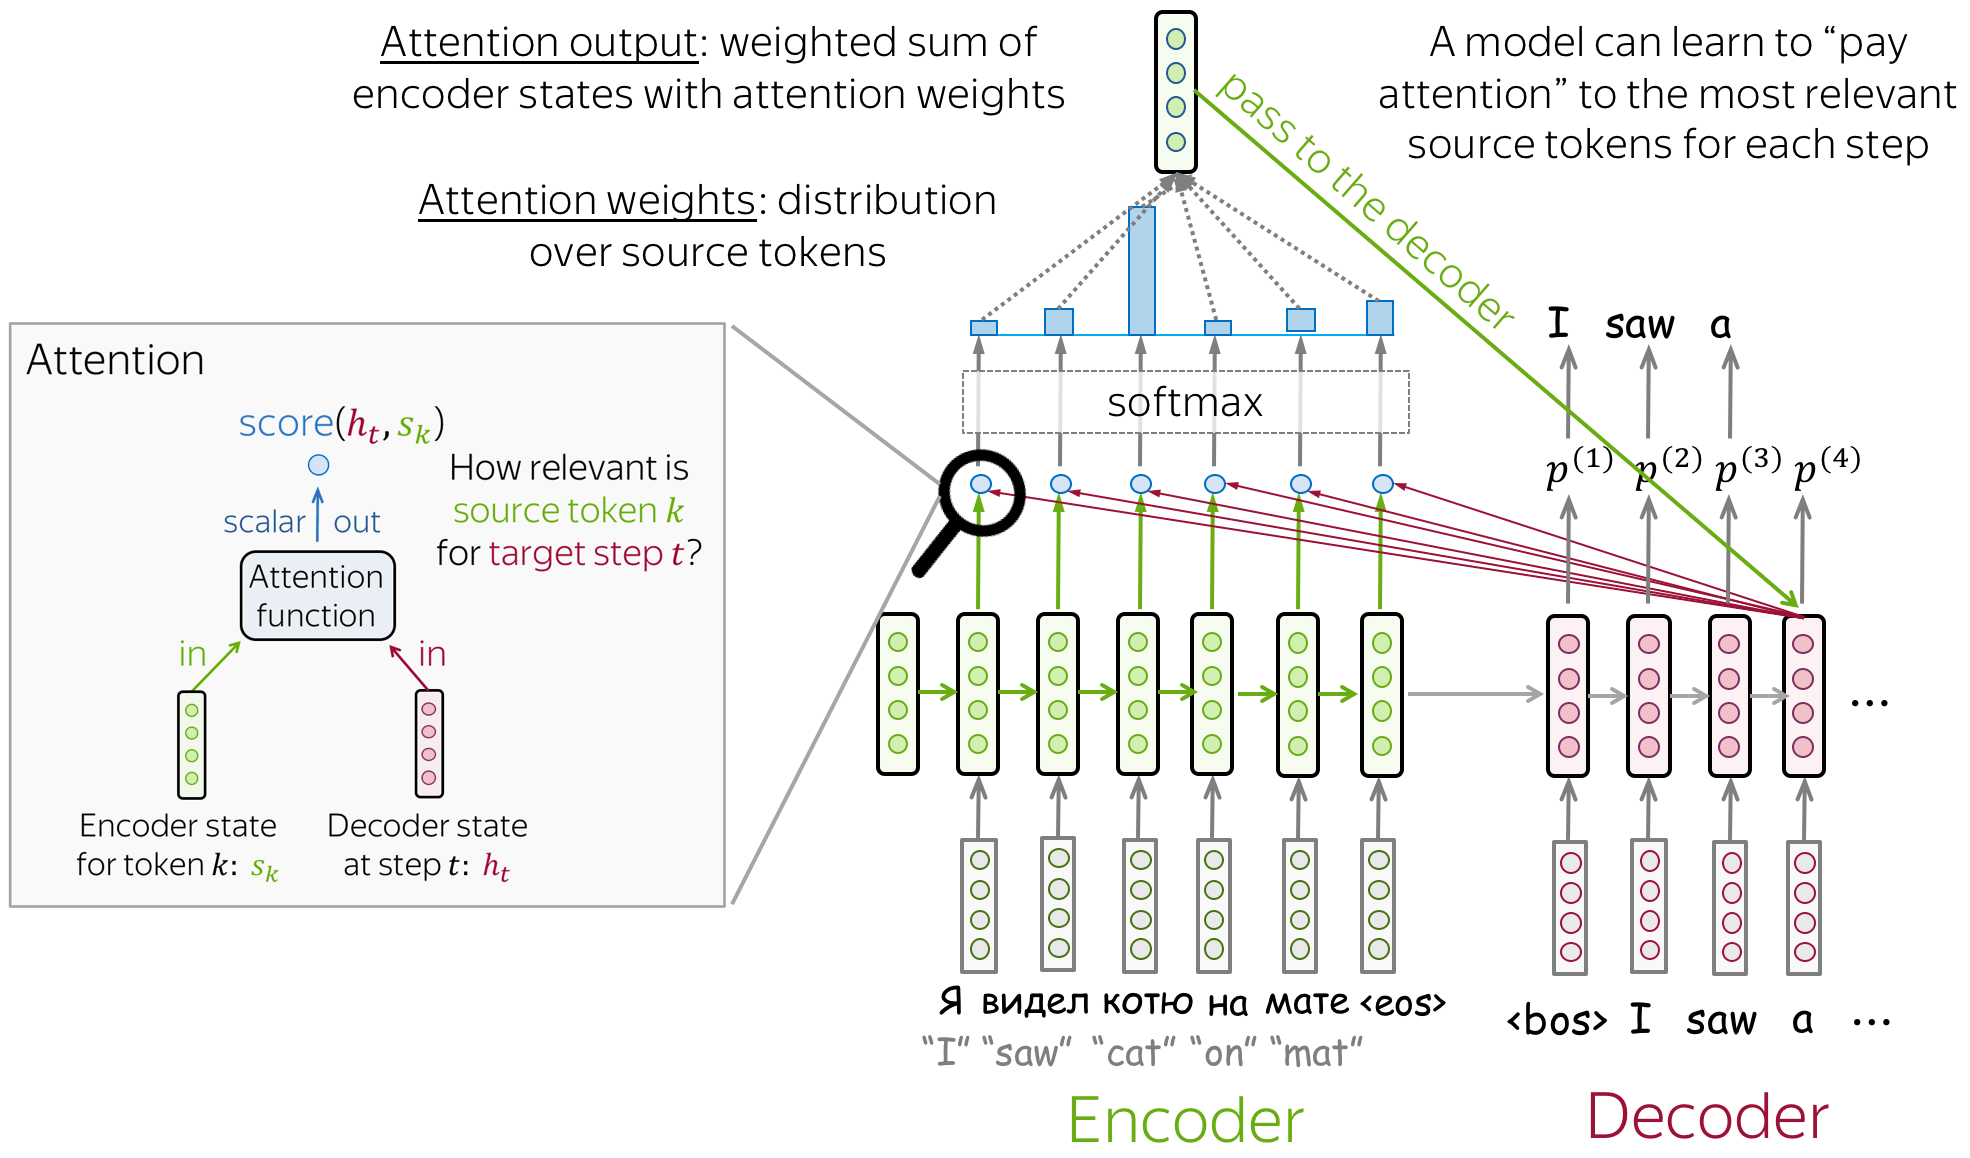

[Voita, L. (2021). Sequence-to-Sequence Models with Attention.](https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html)



In [23]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 18,752,764 trainable parameters


## Model Training

In [24]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = trg_vocab['']).to(device)

In [25]:
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    for i, batch in tqdm(enumerate(iterator), total=len(iterator), desc="Train"):
        src = torch.transpose(batch[0], 0,1).to(device)
        trg = torch.transpose(batch[2], 0,1).to(device)
        optimizer.zero_grad()
        output = model(src, trg)
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].reshape(-1)
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

In [26]:
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, batch in tqdm(enumerate(iterator), total=len(iterator), desc="Evaluate"):
            src = torch.transpose(batch[0], 0, 1).to(device)
            trg = torch.transpose(batch[2], 0, 1).to(device)
            output = model(src, trg, 0)
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].reshape(-1)
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    return epoch_loss / len(iterator)

In [27]:
N_EPOCHS = 25
CLIP = 1
PATIENCE = 2

train_losses, val_losses = [], []

best_loss = float('inf')
early_stop_counter = 0
best_epoch = 0

for epoch in range(N_EPOCHS):
    print(f'Epoch: {epoch+1:02}')
    
    train_loss = train(model, train_loader, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, val_loader, criterion)
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):.3f}', end=' ')
    print(f'\t\tVal. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):.3f}')
        
    train_losses.append(train_loss), val_losses.append(valid_loss)

    if valid_loss < best_loss:
        best_loss, best_epoch = valid_loss, epoch
        torch.save(model.state_dict(), 'model.pt')
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= PATIENCE:
            print(f'Early stopping after epoch {epoch+1}: no improvement for {PATIENCE} epochs.')
            break

if early_stop_counter < PATIENCE:
    print(f'Best validation loss of {best_loss:.3f} at epoch {best_epoch+1}.')

Epoch: 01


Evaluate: 100%|██████████| 44/44 [00:01<00:00, 32.35it/s]


	Train Loss: 5.612 | Train PPL: 273.790 		Val. Loss: 5.345 |  Val. PPL: 209.529
Epoch: 02


Evaluate: 100%|██████████| 44/44 [00:01<00:00, 34.57it/s]


	Train Loss: 4.567 | Train PPL: 96.261 		Val. Loss: 4.454 |  Val. PPL: 86.000
Epoch: 03


Evaluate: 100%|██████████| 44/44 [00:01<00:00, 34.00it/s]


	Train Loss: 3.438 | Train PPL: 31.123 		Val. Loss: 3.733 |  Val. PPL: 41.812
Epoch: 04


Evaluate: 100%|██████████| 44/44 [00:01<00:00, 32.86it/s]


	Train Loss: 2.541 | Train PPL: 12.697 		Val. Loss: 3.499 |  Val. PPL: 33.069
Epoch: 05


Evaluate: 100%|██████████| 44/44 [00:01<00:00, 35.01it/s]


	Train Loss: 1.954 | Train PPL: 7.057 		Val. Loss: 3.488 |  Val. PPL: 32.730
Epoch: 06


Evaluate: 100%|██████████| 44/44 [00:01<00:00, 34.15it/s]


	Train Loss: 1.544 | Train PPL: 4.682 		Val. Loss: 3.537 |  Val. PPL: 34.368
Epoch: 07


Evaluate: 100%|██████████| 44/44 [00:01<00:00, 33.44it/s]


	Train Loss: 1.277 | Train PPL: 3.587 		Val. Loss: 3.644 |  Val. PPL: 38.239
Epoch: 08


Evaluate: 100%|██████████| 44/44 [00:01<00:00, 34.53it/s]

	Train Loss: 1.076 | Train PPL: 2.931 		Val. Loss: 3.788 |  Val. PPL: 44.162
Early stopping after epoch 8: no improvement for 3 epochs.


<span style="font-size:1.1em;">*Perplexity (PPL) is a commonly used evaluation metric in natural language processing tasks. It measures the uncertainty or perplexity of a language model's predictions on a given test set. The lower the perplexity, the better the model is at predicting the test data.</span>


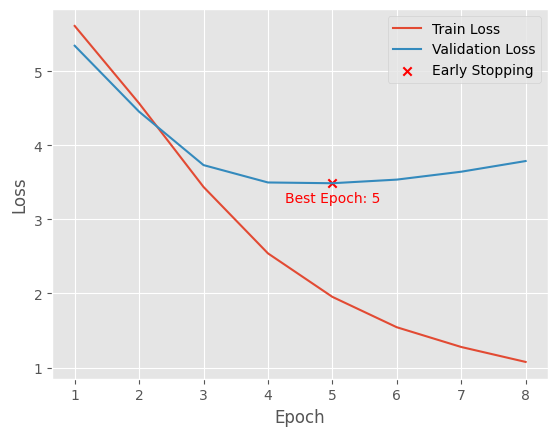

In [37]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.scatter(best_epoch + 1, val_losses[best_epoch], color='red', marker='x', label='Early Stopping')
plt.text(best_epoch + 1, val_losses[best_epoch] - 0.30, f'Best Epoch: {best_epoch + 1}', 
         color='red', fontsize=10, va='bottom', ha='center')
plt.legend()
plt.show()

In [29]:
model.load_state_dict(torch.load('model.pt'))
test_loss = evaluate(model, test_loader, criterion)
print(f'\tTest Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f}')

Evaluate: 100%|██████████| 44/44 [00:01<00:00, 33.27it/s]

	Test Loss: 3.507 | Test PPL:  33.355


## Translation Process

In [30]:
source = "كيف حالك ؟"
input = preprocess(source, src_vocab)
input = input[:,None].to(torch.int64).to(device)

In [31]:
target = torch.zeros(len(source.split(' '))+2,1,).to(torch.int64)

with torch.no_grad():
    model.eval()
    input = input.to(device)
    target = target.to(device)
    output = model(input, target, 0)
    output_dim = output.shape[-1]
    output = output[1:].view(-1, output_dim)

In [32]:
prediction = []
for i in output:
    prediction.append(torch.argmax(i).item())
tokens = trg_vocab.lookup_tokens(prediction)

In [33]:
from nltk.tokenize.treebank import TreebankWordDetokenizer
TreebankWordDetokenizer().detokenize(tokens).replace('', "").replace('"',"").strip()

'how are you ?'